2024-07-14 00:08:09.621498: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 00:08:10.096338: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-14 00:08:11.030508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[*********************100%%**********************]  1 of 1 completed
/home/anupam/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.1973 - val_loss: 0.0045
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084 - val_loss: 0.0058
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0042
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

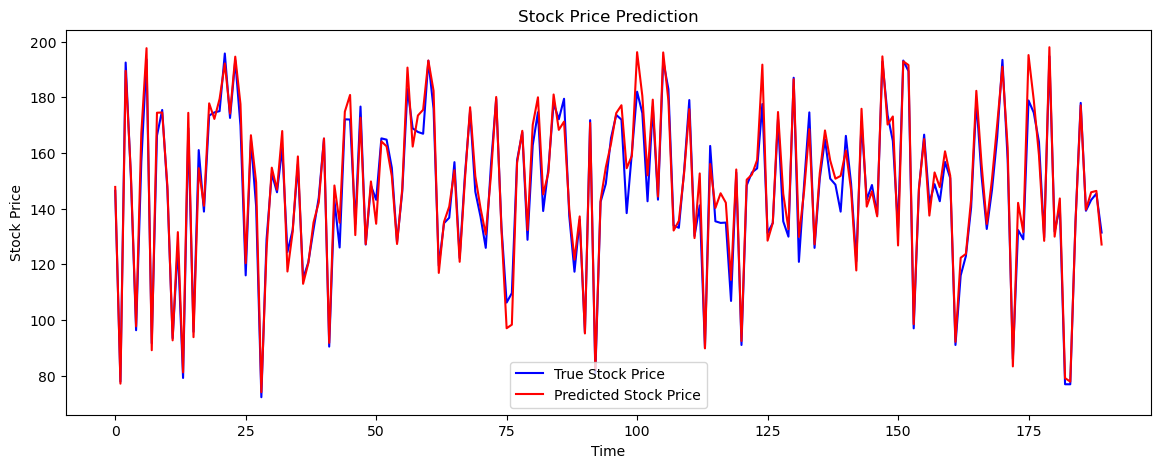

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

# Fetch stock data
ticker = 'AAPL'  # You can replace 'AAPL' with any ticker symbol
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Assuming 'Close' column contains the stock prices
prices = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices = scaler.fit_transform(prices)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to consider for predicting the next day's price
X, y = create_sequences(scaled_prices, seq_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

# Define the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(2, 1), activation='relu', input_shape=(seq_length, 1, 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(tf.keras.layers.Reshape((29, 64)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and inverse transform the predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Inverse transform the true prices
true_prices = scaler.inverse_transform(y_test)

# Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate accuracy
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    accurate_predictions = np.abs((y_true - y_pred) / y_true) < tolerance
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(true_prices, predicted_prices)
print(f'Accuracy: {accuracy:.2f}%')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='blue', label='True Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed

Epoch 1/50



/home/anupam/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.1617 - val_loss: 0.0074
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024 - val_l

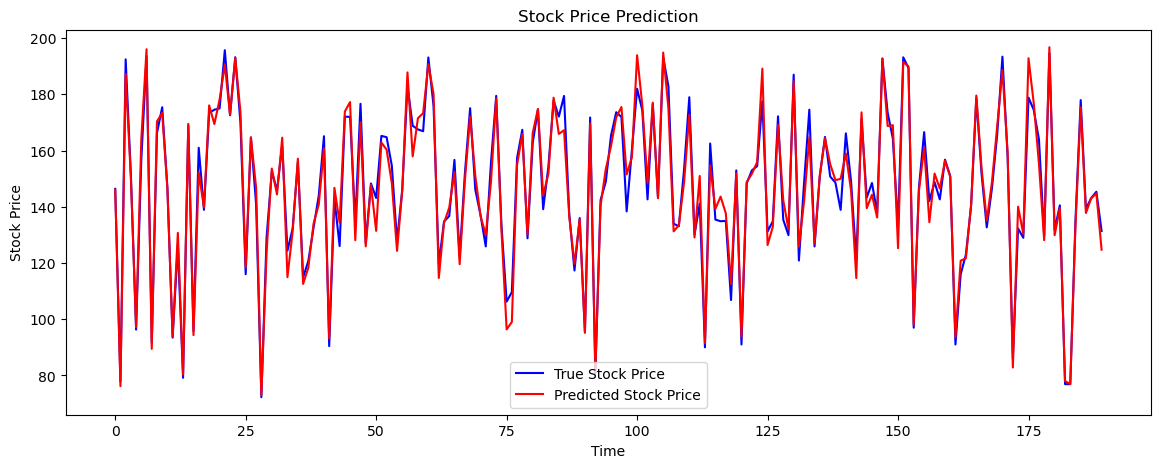

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

# Fetch stock data
ticker = 'AAPL'  # You can replace 'AAPL' with any ticker symbol
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Use multiple features: 'Open', 'High', 'Low', 'Close', 'Volume'
features = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Using the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to consider for predicting the next day's price
X, y = create_sequences(scaled_features, seq_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (Adding an extra dimension for the single channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Define the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(2, 5), activation='relu', input_shape=(seq_length, X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(tf.keras.layers.Reshape((29, 64)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and inverse transform the predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.hstack((np.zeros((predicted_prices.shape[0], 3)), predicted_prices, np.zeros((predicted_prices.shape[0], 1)))))[:, 3]

# Inverse transform the true prices
true_prices = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 3)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 3]

# Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate accuracy
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    accurate_predictions = np.abs((y_true - y_pred) / y_true) < tolerance
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(true_prices, predicted_prices)
print(f'Accuracy: {accuracy:.2f}%')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='blue', label='True Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
/home/anupam/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.1284 - val_loss: 0.0101
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0073 - val_loss: 0.0040
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0026 - val_loss: 0.0037
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

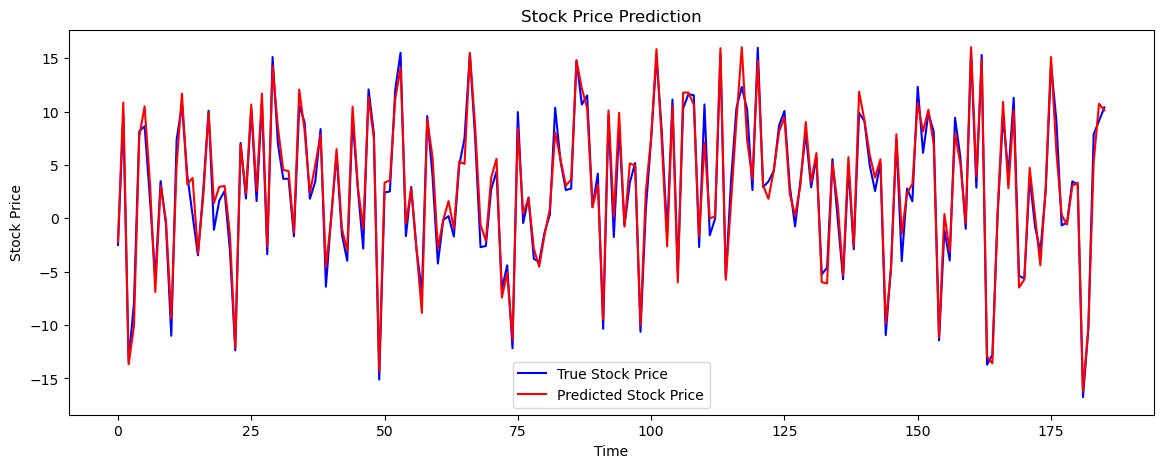

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten
import matplotlib.pyplot as plt

# Fetch stock data
ticker = 'AAPL'  # You can replace 'AAPL' with any ticker symbol
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Calculate additional features
data['SMA'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average
data['EWMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Momentum'] = data['Close'] - data['Close'].shift(4)  # Momentum
data['Volatility'] = data['Close'].rolling(window=20).std()  # Rolling volatility
data.dropna(inplace=True)

# Use multiple features: 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility'
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Using the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to consider for predicting the next day's price
X, y = create_sequences(scaled_features, seq_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (Adding an extra dimension for the single channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Define the model
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(2, X_train.shape[2]), activation='relu', input_shape=(seq_length, X_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 1)))
model.add(Flatten())
model.add(tf.keras.layers.Reshape((29, 64)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and inverse transform the predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.hstack((np.zeros((predicted_prices.shape[0], 7)), predicted_prices, np.zeros((predicted_prices.shape[0], 1)))))[:, 7]

# Inverse transform the true prices
true_prices = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 7)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 7]

# Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate accuracy
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    accurate_predictions = np.abs((y_true - y_pred) / y_true) < tolerance
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(true_prices, predicted_prices)
print(f'Accuracy: {accuracy:.2f}%')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='blue', label='True Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [6]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, BatchNormalization
import matplotlib.pyplot as plt

# Fetch stock data
ticker = 'AAPL'  # You can replace 'AAPL' with any ticker symbol
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Calculate additional features
data['SMA'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average
data['EWMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Momentum'] = data['Close'] - data['Close'].shift(4)  # Momentum
data['Volatility'] = data['Close'].rolling(window=20).std()  # Rolling volatility
data.dropna(inplace=True)

# Use multiple features: 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility'
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Using the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to consider for predicting the next day's price
X, y = create_sequences(scaled_features, seq_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (Adding an extra dimension for the single channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Define the model
model = Sequential()

# Adding more Conv2D layers
model.add(Conv2D(filters=64, kernel_size=(2, X_train.shape[2]), activation='relu', input_shape=(seq_length, X_train.shape[2], 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=128, kernel_size=(2, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=256, kernel_size=(2, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Flatten())

# Adding more LSTM layers
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and inverse transform the predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.hstack((np.zeros((predicted_prices.shape[0], 7)), predicted_prices, np.zeros((predicted_prices.shape[0], 1)))))[:, 7]

# Inverse transform the true prices
true_prices = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 7)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 7]

# Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate accuracy
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    accurate_predictions = np.abs((y_true - y_pred) / y_true) < tolerance
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(true_prices, predicted_prices)
print(f'Accuracy: {accuracy:.2f}%')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='blue', label='True Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
/home/anupam/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Input 0 of layer "lstm_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1536)

In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout, BatchNormalization, Reshape
import matplotlib.pyplot as plt

# Fetch stock data
ticker = 'AAPL'  # You can replace 'AAPL' with any ticker symbol
data = yf.download(ticker, start='2020-01-01', end='2023-12-31')

# Calculate additional features
data['SMA'] = data['Close'].rolling(window=20).mean()  # Simple Moving Average
data['EWMA'] = data['Close'].ewm(span=20, adjust=False).mean()  # Exponential Moving Average
data['Momentum'] = data['Close'] - data['Close'].shift(4)  # Momentum
data['Volatility'] = data['Close'].rolling(window=20).std()  # Rolling volatility
data.dropna(inplace=True)

# Use multiple features: 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility'
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EWMA', 'Momentum', 'Volatility']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Using the 'Close' price as the target
    return np.array(X), np.array(y)

seq_length = 60  # Number of past days to consider for predicting the next day's price
X, y = create_sequences(scaled_features, seq_length)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape for CNN input (Adding an extra dimension for the single channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Define the model
model = Sequential()

# Adding more Conv2D layers
model.add(Conv2D(filters=64, kernel_size=(2, X_train.shape[2]), activation='relu', input_shape=(seq_length, X_train.shape[2], 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=128, kernel_size=(2, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Conv2D(filters=256, kernel_size=(2, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 1)))

model.add(Flatten())

# Calculate the correct shape for Reshape layer
n_timesteps = 28  # This should be carefully calculated based on the layers
n_features = 256  # The number of features after flattening

# Adding Reshape layer to match LSTM input
model.add(Reshape((n_timesteps, n_features)))

# Adding more LSTM layers
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Predict and inverse transform the predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(np.hstack((np.zeros((predicted_prices.shape[0], 7)), predicted_prices, np.zeros((predicted_prices.shape[0], 1)))))[:, 7]

# Inverse transform the true prices
true_prices = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 7)), y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 1)))))[:, 7]

# Calculate metrics
mae = mean_absolute_error(true_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(true_prices, predicted_prices))
mape = mean_absolute_percentage_error(true_prices, predicted_prices)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')

# Calculate accuracy
def calculate_accuracy(y_true, y_pred, tolerance=0.05):
    accurate_predictions = np.abs((y_true - y_pred) / y_true) < tolerance
    accuracy = np.mean(accurate_predictions) * 100
    return accuracy

accuracy = calculate_accuracy(true_prices, predicted_prices)
print(f'Accuracy: {accuracy:.2f}%')

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(true_prices, color='blue', label='True Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed
/home/anupam/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(1536,), target_shape=(28, 256)